import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch_cls import *
from utils.trainval_cls_withMasking import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step005_clsMasking_P007_resnetScratch' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:2'
print(device)

freqShow = 100

#model parameters
batch_size = 18
newSize = [128, 128]
total_epoch_num = 500  # total number of epoch in training
base_lr = 0.0005      # base learning rate/


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:2


In [3]:
with open('dbinfo_cls.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)


cls_datasets = {set_name: PollenCls(dbinfo, size=[128, 128], set_name=set_name)
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

42115 4720


In [4]:
data_sampler = iter(dataloaders['train'])

In [5]:
data = next(data_sampler)
image, segMask, label = data

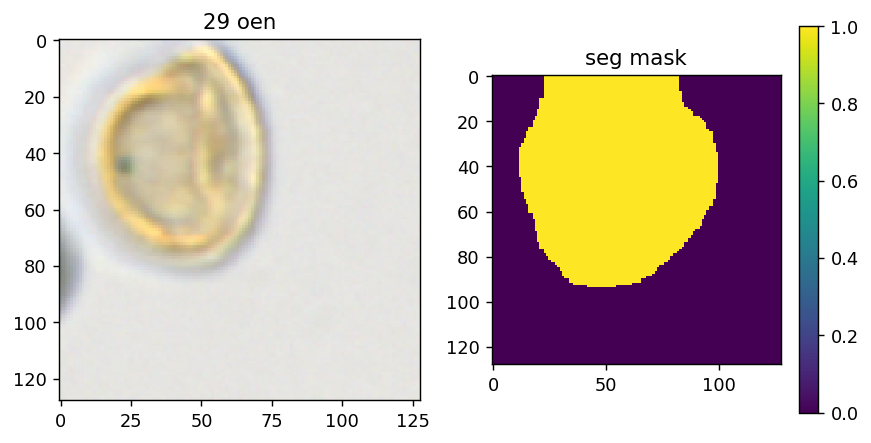

In [6]:
idx = 11
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = round(tmplabel.item())
labelName = dbinfo['meta'][tmplabel-1]


numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 2
plt.figure(figsize=(8, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('{:02d} '.format(tmplabel)+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()

In [7]:
max(dbinfo['perClassCount']), min(dbinfo['perClassCount'])

(10055, 86)

Text(0, 0.5, 'number in train set')

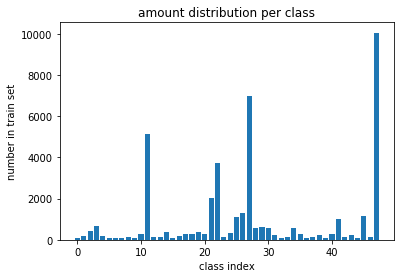

In [8]:
plt.bar(list(range(48)), dbinfo['perClassCount'])
plt.title('amount distribution per class')
plt.xlabel('class index')
plt.ylabel('number in train set')

In [9]:
################## init model ###################
initModel = PollenClsNet(34, pretrained=False)
initModel.to(device);

using pretrained model


In [10]:
image = image.to(device)
label = label.type(torch.long).view(-1).to(device)
outputs = initModel(image)

In [11]:
lossFunc_cls = nn.CrossEntropyLoss()

#weight = torch.ones(2)
#weight[0] = 0.5
#weight = weight.to(device)
# lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')

In [12]:
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [13]:
optimizer = optim.Adam([{'params': initModel.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

In [14]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_cls, optimizer, exp_lr_scheduler,                       
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, device=device, freqShow=freqShow)


Epoch 1/500
----------
train
	100/1755 loss:2.900
	200/1755 loss:2.690
	300/1755 loss:2.544
	400/1755 loss:2.431
	500/1755 loss:2.350
	600/1755 loss:2.284
	700/1755 loss:2.235
	800/1755 loss:2.199
	900/1755 loss:2.164
	1000/1755 loss:2.134
	1100/1755 loss:2.106
	1200/1755 loss:2.081
	1300/1755 loss:2.063
	1400/1755 loss:2.060
	1500/1755 loss:2.045
	1600/1755 loss:2.024
	1700/1755 loss:2.005
	loss: 1.997201
test
	100/197 loss:1.689
	loss: 1.654080

Epoch 2/500
----------
train
	100/1755 loss:1.688
	200/1755 loss:1.737
	300/1755 loss:1.734




Leaving Blank
-----